In [1]:
import requests
import gzip
import shutil
import shlex
import subprocess as sp
import json

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys

sys.path.insert(0, '../src')
from util import plot_pca, plot_eigenval

from bioinfokit import analys, visuz

In [2]:
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

def uncompress(filename):
    cmd = shlex.split(("unzip {} -d ../data").format(filename))
    sp.call(cmd)
    
def load_params(fp):
    with open(fp) as fh:
        param = json.load(fh)

    return param

## Get data


In [3]:
cfg = load_params("../config/data-params.json")
for file_id, filename in cfg['files']:
    destination = '../data/'+filename
    download_file_from_google_drive(file_id, destination)
    uncompress(destination)

KeyboardInterrupt: 

## EDA

### SNPs

In [3]:
df = pd.read_table('../data/crytic.map', header=None)
d

,0,1,2,3
0,1,rs3094315,0,792429
1,1,rs2980300,0,825852
2,1,rs4075116,0,1043552
3,1,rs9442385,0,1137258
4,1,rs10907175,0,1170650
5,1,rs2887286,0,1196054
6,1,rs6603781,0,1198554
7,1,rs11260562,0,1205233
8,1,rs6685064,0,1251215
9,1,rs307378,0,1308770


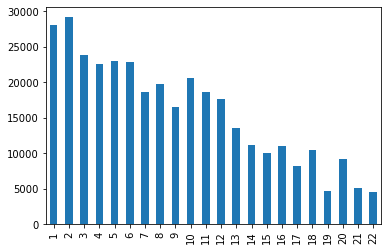

In [11]:
df[0].value_counts().sort_index().plot(kind = 'bar')

### ped file

In [28]:
df = pd.read_table('../data/crytic.ped', header=None)
df[0] = df[0].apply(lambda x: x.split(' ')[:6])
for i in range(1,7):
    df[str(i)] = df[0].apply(lambda x:x[i-1])
df = df.drop(0, axis=1)
df.columns = ['FID', 'IID', 'Father', 'Mother', 'Sex', 'Phenotype']
df

,FID,IID,Father,Mother,Sex,Phenotype
0,WGAAD,10,0,0,2,2
1,WGAAD,15,0,0,1,2
2,WGAAD,18,0,0,1,2
3,WGAAD,20,0,0,1,2
4,WGAAD,24,0,0,2,2
5,WGAAD,25,0,0,2,2
6,WGAAD,28,0,0,2,2
7,WGAAD,29,0,0,1,2
8,WGAAD,31,0,0,1,2
9,WGAAD,35,0,0,2,2


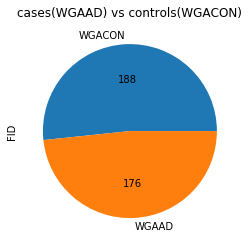

In [48]:
df['FID'].value_counts().plot(kind='pie', title = 'cases(WGAAD) vs controls(WGACON)', autopct=lambda x:int(x*364/100))

In [50]:
df['FID'].value_counts()

WGACON    188
WGAAD     176
Name: FID, dtype: int64

In [51]:
df['Sex'].value_counts()

1    191
2    173
Name: Sex, dtype: int64

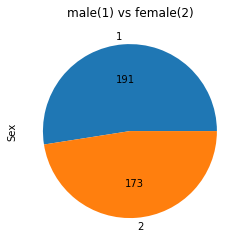

In [52]:
df['Sex'].value_counts().plot(kind='pie', title = 'male(1) vs female(2)', autopct=lambda x:int(x*364/100)+1)

In [42]:
df[['Father', 'Mother']].astype(int).sum()

Father    0
Mother    0
dtype: int64

### PCA

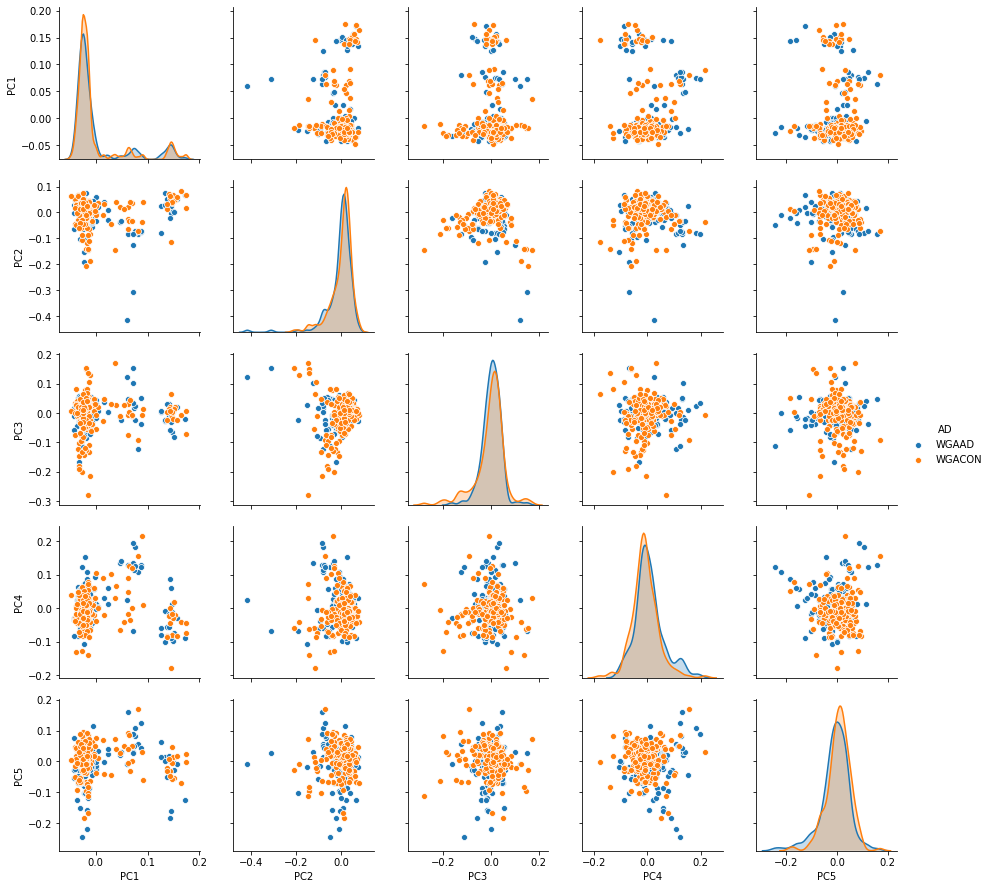

In [2]:
plot_pca('../data/pca.eigenvec')

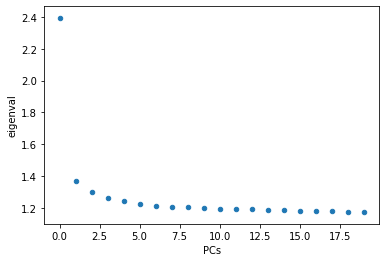

In [2]:
plot_eigenval('../data/pca.eigenval')

### Logistic

In [56]:
def regional_manhattan(df, gene, chromo, start, end, gap=500000):
    
    def set_color(pos, start, end, gene):
        if pos<start:
            return 'AALeft'
        elif pos>end:
            return 'ZRight'
        return gene
    temp=df[(df['BP'].astype(int)>(int(start)-gap)) & (df['BP'].astype(int)<(int(end)+gap)) & (df['CHR']==chromo)]
    
    temp['color'] = temp['BP'].apply(lambda x: set_color(x, start, end, gene))
    visuz.marker.mhat(df=temp, chr='color',pv='P', show=True, gwas_sign_line=True, dim=(15,10), axxlabel='{} (Chromosome {})'.format(gene, str(chromo)), dotsize=10)

In [2]:
df = pd.read_table('../data/pca1.assoc.logistic', delim_whitespace=True)
df

,CHR,SNP,BP,A1,TEST,NMISS,OR,SE,L95,U95,STAT,P
0,1,rs3094315,792429,C,ADD,361,1.3090,0.2065,0.873500,1.963,1.305000,0.19180
1,1,rs3094315,792429,C,COV1,361,0.8709,2.0260,0.016430,46.170,-0.068220,0.94560
2,1,rs2980300,825852,A,ADD,342,1.2650,0.2158,0.829000,1.931,1.091000,0.27540
3,1,rs2980300,825852,A,COV1,342,0.8403,2.0490,0.015160,46.590,-0.084920,0.93230
4,1,rs4075116,1043552,G,ADD,363,1.0350,0.1600,0.756600,1.417,0.216900,0.82830
5,1,rs4075116,1043552,G,COV1,363,1.4320,2.0070,0.028010,73.210,0.178900,0.85800
6,1,rs9442385,1137258,T,ADD,362,0.7017,0.2723,0.411500,1.197,-1.301000,0.19330
7,1,rs9442385,1137258,T,COV1,362,1.7450,2.0090,0.034030,89.490,0.277200,0.78160
8,1,rs10907175,1170650,C,ADD,353,1.1940,0.2785,0.691700,2.061,0.636500,0.52440
9,1,rs10907175,1170650,C,COV1,353,1.0820,2.0610,0.019060,61.440,0.038360,0.96940


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


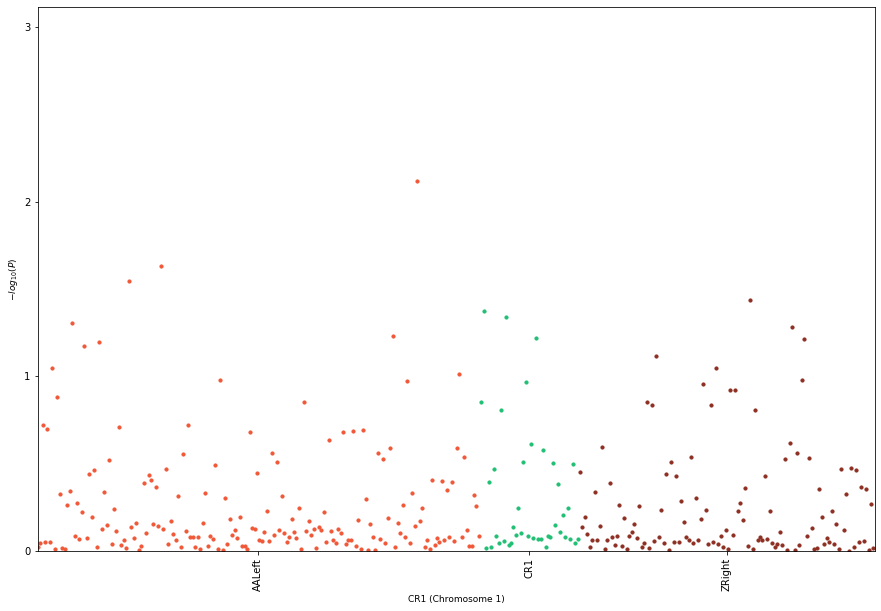

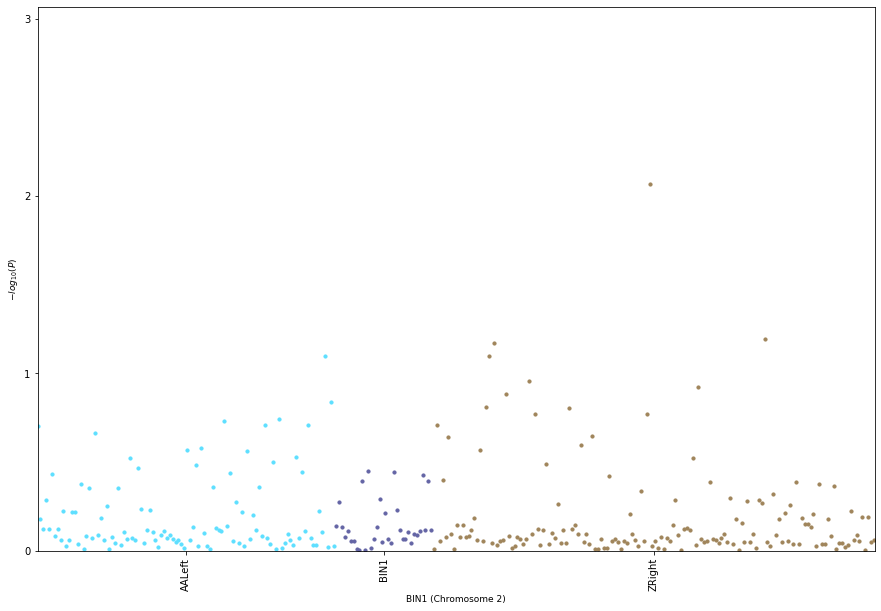

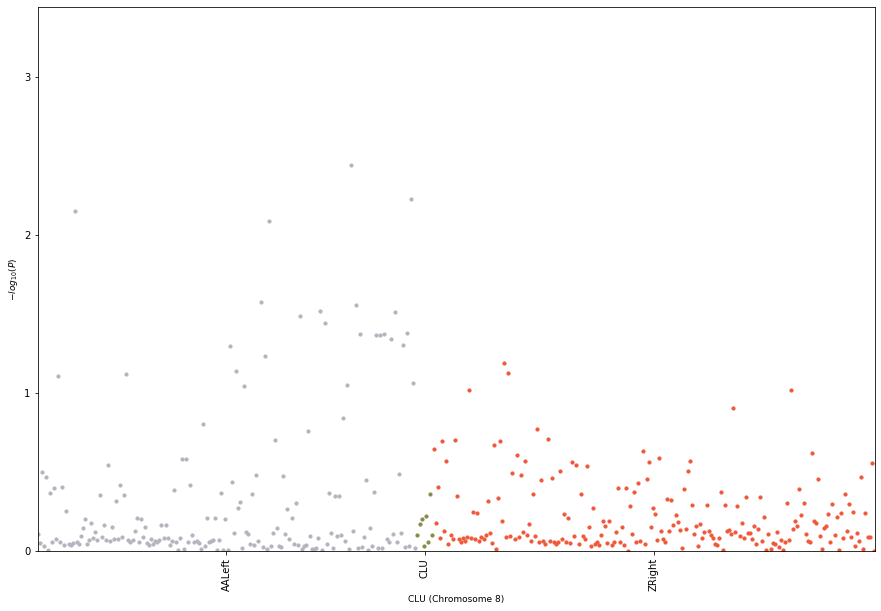

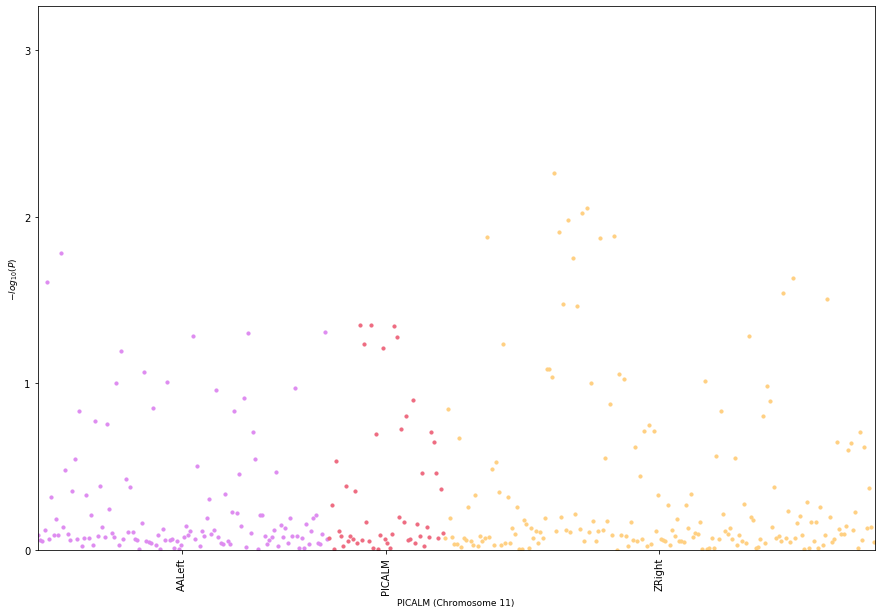

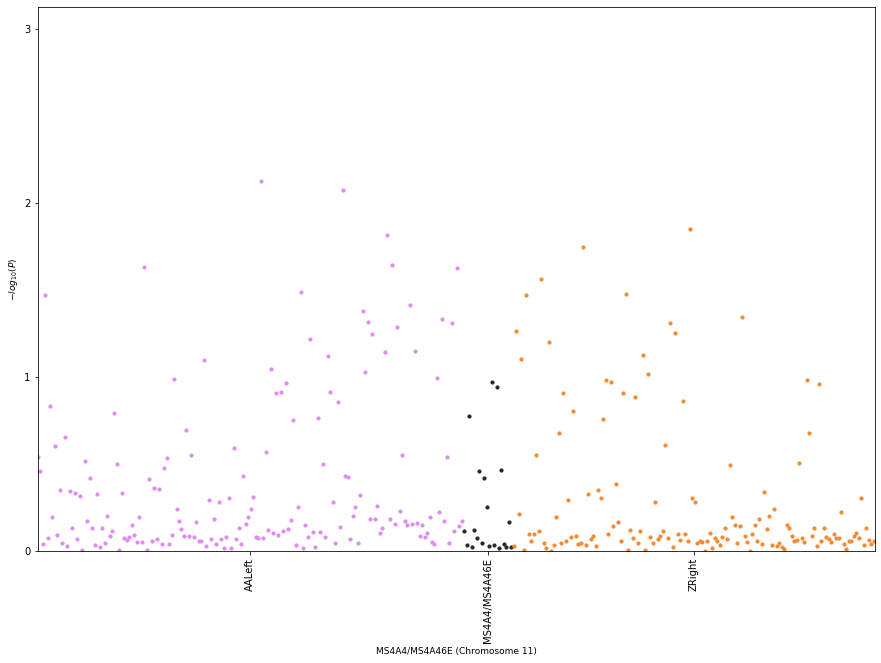

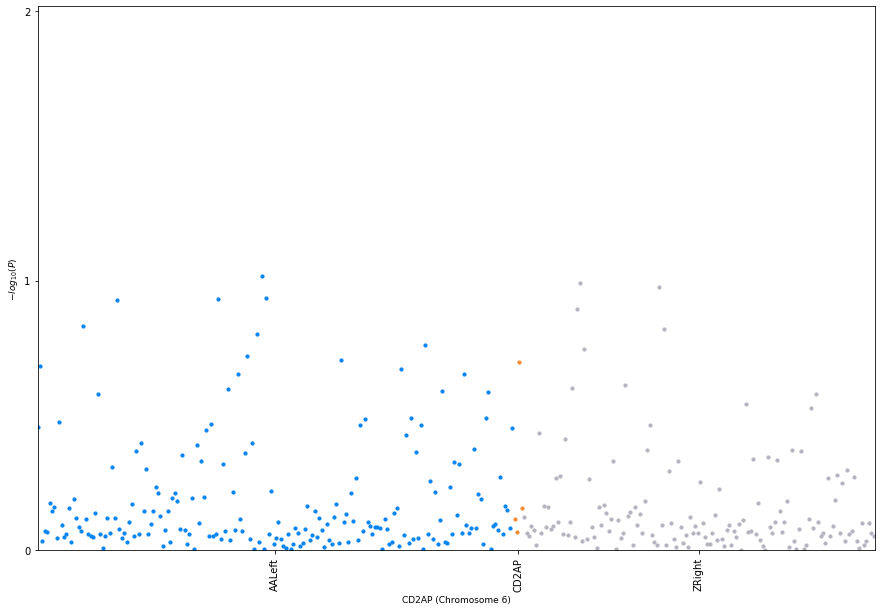

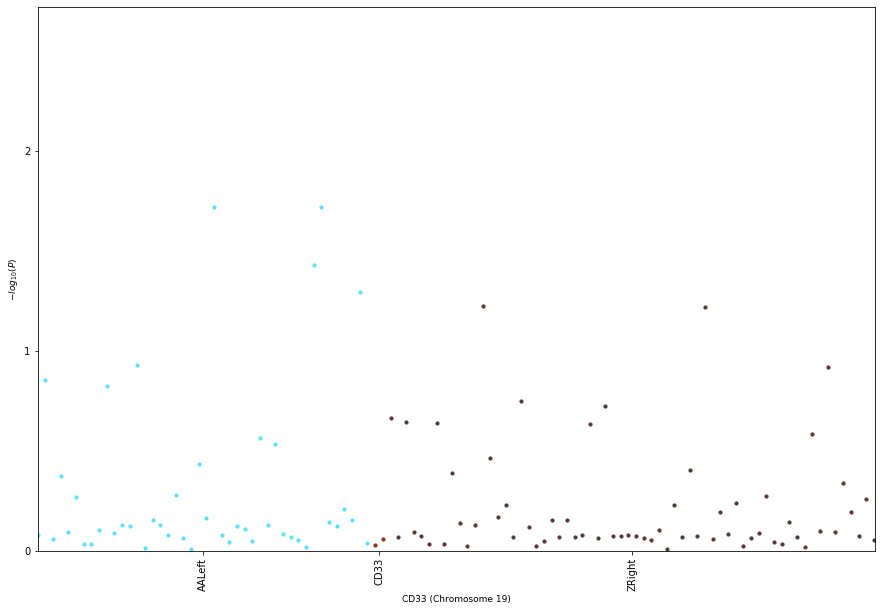

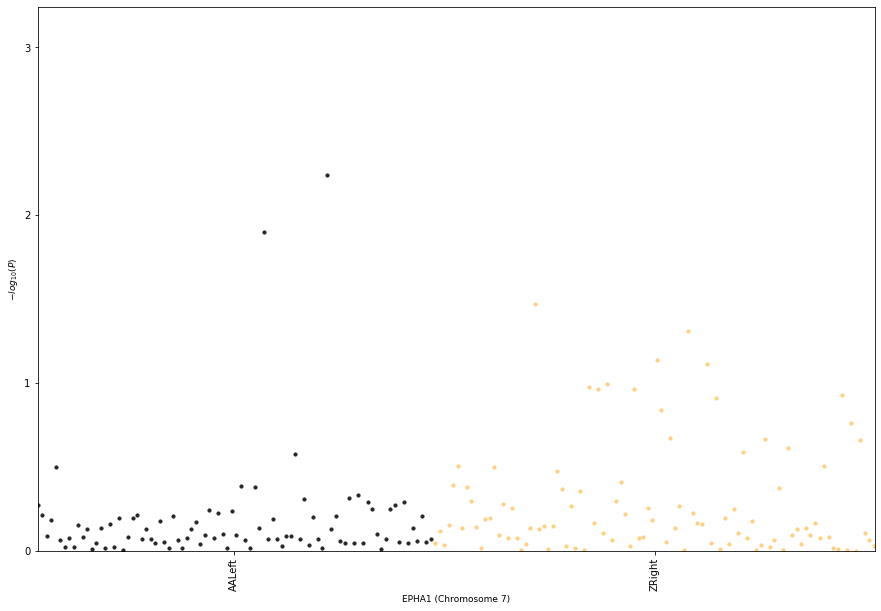

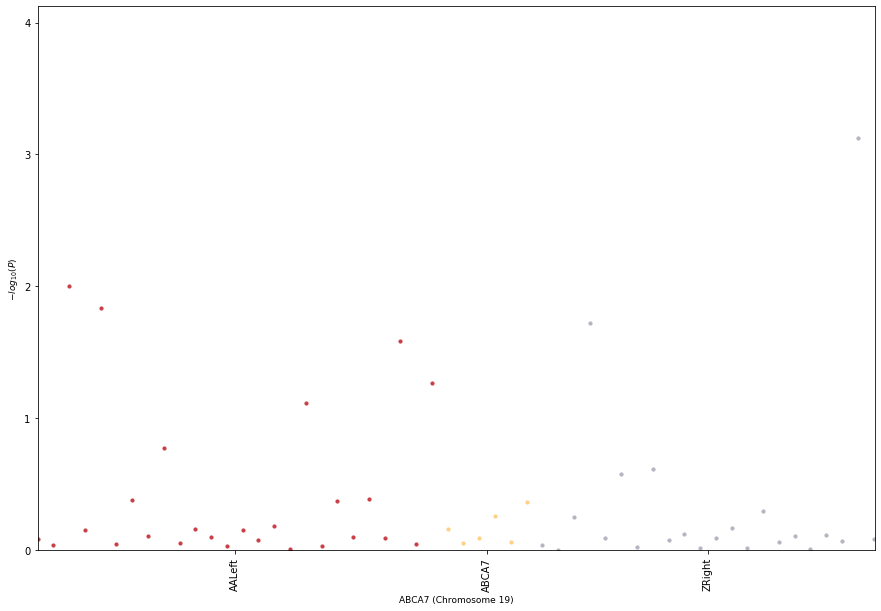

In [58]:
genes = pd.read_csv('../data/9gene.csv')
for i, row in genes.iterrows():
    regional_manhattan(df, row['gene'], row['chr'], row['start'], row['end'])

In [29]:
genes.drop(0)

,gene,start,end,chr
1,BIN1,127048023,127107154,2
2,CLU,27596917,27615031,8
3,PICALM,85957175,86069860,11
4,MS4A4/MS4A46E,60185702,60317944,11
5,CD2AP,47477746,47627263,6
6,CD33,51215537,51243860,19
7,EPHA1,143390289,143408892,7
8,ABCA7,1040107,1065572,19


In [26]:
temp=df[(df['BP']>(row['start']-50000000)) & (df['BP']<(row['end']+50000000)) & (df['CHR']==1)]
temp

,CHR,SNP,BP,A1,TEST,NMISS,OR,SE,L95,U95,STAT,P,tpval


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


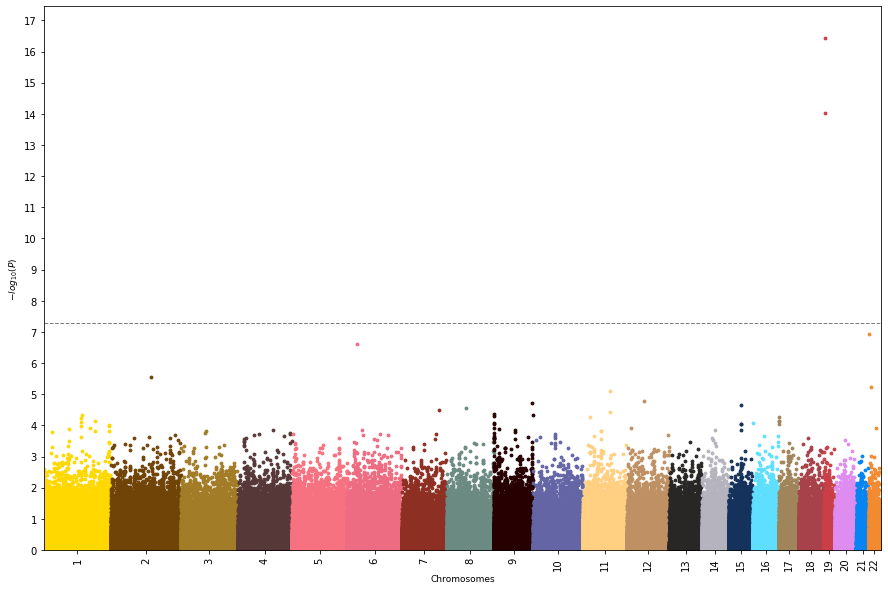

In [6]:
visuz.marker.mhat(df=df, chr='CHR',pv='P', show=True, gwas_sign_line=True, dim=(15,10))

In [4]:
df.sort_values('P')

,CHR,SNP,BP,A1,TEST,NMISS,OR,SE,L95,U95,STAT,P
658132,19,rs429358,50103781,C,ADD,364,6.2410,0.2173,4.0760,9.5550,8.426,3.566000e-17
658134,19,rs4420638,50114786,C,ADD,364,4.4380,0.1923,3.0450,6.4700,7.750,9.171000e-15
694702,22,rs867198,37033106,T,ADD,345,5.4450,0.3194,2.9110,10.1800,5.306,1.122000e-07
276384,6,rs3011823,83208939,G,ADD,340,10.2800,0.4508,4.2490,24.8700,5.169,2.356000e-07
68958,2,rs9309095,43147102,T,ADD,335,2.1800,0.1662,1.5740,3.0190,4.688,2.755000e-06
694336,22,rs4821510,35327956,T,ADD,361,0.3785,0.2143,0.2487,0.5761,-4.533,5.810000e-06
457216,11,rs1155331,22342766,T,ADD,349,2.3650,0.1924,1.6220,3.4480,4.474,7.664000e-06
515662,12,rs11114028,107598413,T,ADD,358,2.0770,0.1696,1.4890,2.8960,4.309,1.642000e-05
386418,9,rs7043927,28884989,C,ADD,349,0.3948,0.2172,0.2579,0.6043,-4.280,1.873000e-05
575622,15,rs1393404,35933784,T,ADD,340,0.5089,0.1591,0.3726,0.6952,-4.246,2.180000e-05
